## IBM Applied Data Science Capstone Course by Coursera

### Week 5 Final project


## Introduction

In this project,comparsion of neighborhoods of Toronto city and Manhattan, NY, for the popular places with food courts is shown. The tasks involved here are given below.
* Convert addresses into their equivalent latitude and longitude values.
* Use of Foursquare API to explore neighborhoods in Toronto and New York City.
* Neighborhood having the food courts along with the food courts are shown as clusters.
* Used the *k*-means clustering algorithm to generate clusters.
* Finally, the Folium library is used to visualize the neighborhoods in Toronto and Manhattan, New York, and their emerging clusters.

## 1. Import libraries


In [2]:
import numpy as np # library to handle data in a vectorized manner
!pip install beautifulsoup4
!pip install lxml
!pip install html5lib
!pip install folium

from bs4 import BeautifulSoup
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
!pip install geopy
!pip install wordcloud
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import matplotlib.pyplot as plt

from sklearn import metrics

from PIL import Image
import matplotlib.patches as mpatches

from wordcloud import WordCloud, get_single_color_func

print('Libraries imported.')

     |████████████████████████████████| 92kB 7.6MB/s eta 0:00:011
     |████████████████████████████████| 368kB 17.8MB/s eta 0:00:01
Libraries imported.


## 2. Download and Explore Dataset for Toronto, CA


In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [4]:
req = requests.get("https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=935851093")

soup = BeautifulSoup(req.content,'lxml')

table = soup.find_all('table')[0]

df = pd.read_html(str(table))
dt=pd.DataFrame(df[0])

dt = dt[dt.Borough != 'Not assigned'].reset_index(drop=True)

t1=dt.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(','.join).reset_index()
t2=t1.sort_values(by=['Postcode', 'Borough', 'Neighbourhood'])

t2['Neighbourhood']=t2['Neighbourhood'].replace('Not assigned', t2['Borough'])
#t2

In [5]:
geo_df = pd.read_csv('http://cocl.us/Geospatial_data')
result1 = pd.concat([t2, geo_df], axis=1, join='inner')
df_new=result1[['Postal Code','Borough','Neighbourhood','Latitude','Longitude']]
#df_new

## 3. Get the geographical coordinates for Toronto, CA

In [6]:
address1 = 'Toronto, CA'

geolocator = Nominatim(user_agent="ca_explorer")
location1 = geolocator.geocode(address1)
latitude1 = location1.latitude
longitude1 = location1.longitude

print('The geographical coordinate of Toronto are {}, {}.'.format(latitude1, longitude1))#'{}, {}.'.format(latitude, longitude)

The geographical coordinate of Toronto are 43.6534817, -79.3839347.


In [7]:
CLIENT_ID = 'MPH2TVNTPTHNZ5H2DDTMKFZMVFCYCZAGJVQBHPLF2CU0K5P3' # your Foursquare ID
CLIENT_SECRET = '31AGBHLGG5MF3XPYAGSZDFGFVTXJS5VLNXYDRIRJDGJ1U0PI' # your Foursquare SecretVERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MPH2TVNTPTHNZ5H2DDTMKFZMVFCYCZAGJVQBHPLF2CU0K5P3
CLIENT_SECRET:31AGBHLGG5MF3XPYAGSZDFGFVTXJS5VLNXYDRIRJDGJ1U0PI


#### Load and explore the data

In [8]:
searchfor=('Toronto', 'York','Etobicoke')
toronto_data = df_new[df_new['Borough'].astype(str).str.contains('|'.join(searchfor))]
toronto_data= toronto_data.reset_index(drop=True)
toronto_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M2H,North York,Hillcrest Village,43.803762,-79.363452
1,M2J,North York,"Fairview,Henry Farm,Oriole",43.778517,-79.346556
2,M2K,North York,Bayview Village,43.786947,-79.385975
3,M2L,North York,"Silver Hills,York Mills",43.757490,-79.374714
4,M2M,North York,"Newtonbrook,Willowdale",43.789053,-79.408493


Let's take a quick look at the data.

In [9]:
neighbourhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighbourhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighbourhood_name = toronto_data.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Hillcrest Village are 43.8037622, -79.3634517.


In [10]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius
VERSION = '20180605' # Foursquare API version

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=MPH2TVNTPTHNZ5H2DDTMKFZMVFCYCZAGJVQBHPLF2CU0K5P3&client_secret=31AGBHLGG5MF3XPYAGSZDFGFVTXJS5VLNXYDRIRJDGJ1U0PI&v=20180605&ll=43.8037622,-79.3634517&radius=500&limit=100'

In [11]:
results1 = requests.get(url).json()
#results1

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
venues1 = results1['response']['groups'][0]['items']
    
nearby_venues1 = json_normalize(venues1) # flatten JSON

# filter columns
filtered_columns1 = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues1 =nearby_venues1.loc[:, filtered_columns1]

# filter the category for each row
nearby_venues1['venue.categories'] = nearby_venues1.apply(get_category_type, axis=1)

# clean columns
nearby_venues1.columns = [col.split(".")[-1] for col in nearby_venues1.columns]

nearby_venues1.head()

,name,categories,lat,lng
0,Eagle's Nest Golf Club,Golf Course,43.805455,-79.364186
1,New York Fries,Fast Food Restaurant,43.803664,-79.363905
2,AY Jackson Pool,Pool,43.804515,-79.366138
3,Villa Madina,Mediterranean Restaurant,43.801685,-79.363938
4,Duncan Creek Park,Dog Run,43.805539,-79.360695


In [14]:
print('{} venues were returned by Foursquare.'.format(nearby_venues1.shape[0]))

5 venues were returned by Foursquare.


In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
# type your answer here
toronto_venues = getNearbyVenues(names= toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Bedford 

In [17]:
print(toronto_venues.shape)
toronto_venues.head()

(2067, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hillcrest Village,43.803762,-79.363452,Eagle's Nest Golf Club,43.805455,-79.364186,Golf Course
1,Hillcrest Village,43.803762,-79.363452,New York Fries,43.803664,-79.363905,Fast Food Restaurant
2,Hillcrest Village,43.803762,-79.363452,AY Jackson Pool,43.804515,-79.366138,Pool
3,Hillcrest Village,43.803762,-79.363452,Villa Madina,43.801685,-79.363938,Mediterranean Restaurant
4,Hillcrest Village,43.803762,-79.363452,Duncan Creek Park,43.805539,-79.360695,Dog Run


In [18]:
toronto_venues.groupby("Neighborhood").count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",12,12,12,12,12,12
"Alderwood,Long Branch",11,11,11,11,11,11
"Bathurst Manor,Downsview North,Wilson Heights",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park,Lawrence Manor East",23,23,23,23,23,23
Berczy Park,56,56,56,56,56,56
"Bloordale Gardens,Eringate,Markland Wood,Old Burnhamthorpe",7,7,7,7,7,7
"Brockton,Exhibition Place,Parkdale Village",22,22,22,22,22,22


In [19]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 260 uniques categories.


### 4. Analyze Each Neighborhood in Toronto, CA

In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()
#toronto_venues['Neighborhood']

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Social Club,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Hillcrest Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [21]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
#toronto_grouped

In [22]:
toronto_grouped["Food Court"].value_counts()

0.000000    77
0.010000     4
0.014493     1
0.031250     1
Name: Food Court, dtype: int64

In [23]:
toronto_foodcourt=toronto_grouped[['Neighbourhood', 'Food Court']]
toronto_foodcourt.shape

(83, 2)

In [24]:
toronto_foodcourt.head()

,Neighbourhood,Food Court
0,"Adelaide,King,Richmond",0.01
1,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.00
2,"Alderwood,Long Branch",0.00
3,"Bathurst Manor,Downsview North,Wilson Heights",0.00
4,Bayview Village,0.00


In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Restaurant,Gym,Bakery,Thai Restaurant,Hotel,Bookstore,Bar,Steakhouse
1,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Beer Store,Japanese Restaurant,Sandwich Place,Discount Store,Liquor Store,Video Store,Pharmacy
2,"Alderwood,Long Branch",Pizza Place,Coffee Shop,Pub,Athletics & Sports,Sandwich Place,Pool,Dance Studio,Pharmacy,Gym,Skating Rink
3,"Bathurst Manor,Downsview North,Wilson Heights",Bank,Coffee Shop,Deli / Bodega,Pizza Place,Sushi Restaurant,Middle Eastern Restaurant,Shopping Mall,Restaurant,Diner,Fried Chicken Joint
4,Bayview Village,Japanese Restaurant,Bank,Chinese Restaurant,Café,Yoga Studio,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore


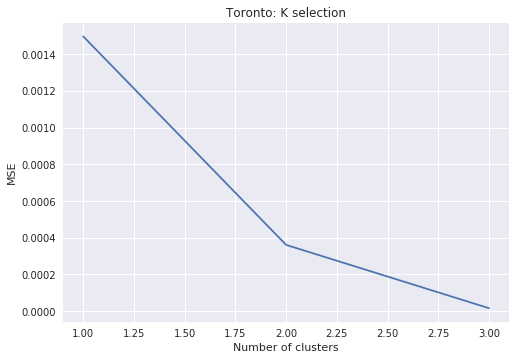

 The number of Kclusters set:  3


In [27]:
# Finding best k
plt.style.use("seaborn")
Ks = 4
mse = np.zeros((Ks-1))
toronto_grouped_clustering = toronto_foodcourt.drop('Neighbourhood', 1)

for n in range(1,Ks):
    kclusters1 = n
# run k-means clustering
    kmeans1 = KMeans(n_clusters=kclusters1, random_state=0,init = 'random', n_init = 15).fit(toronto_grouped_clustering)
    mse[n-1] = kmeans1.inertia_
    
plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("Toronto: K selection")
plt.show()
 
print(' The number of Kclusters set: ', kclusters1)

In [28]:
# check cluster labels generated for each row in the dataframe
kmeans1.labels_[0:10] 

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [29]:
# set number of clusters
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans1.labels_)
toronto_merged=toronto_foodcourt.copy()
toronto_merged = toronto_data.join(toronto_foodcourt.set_index('Neighbourhood'), on='Neighbourhood')
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Food Court,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M2H,North York,Hillcrest Village,43.803762,-79.363452,0.00000,0.0,Mediterranean Restaurant,Golf Course,Fast Food Restaurant,Dog Run,Pool,Donut Shop,Diner,Discount Store,Distribution Center,Doner Restaurant
1,M2J,North York,"Fairview,Henry Farm,Oriole",43.778517,-79.346556,0.03125,1.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Restaurant,Tea Room,Women's Store,Food Court,Bank,Bakery
2,M2K,North York,Bayview Village,43.786947,-79.385975,0.00000,0.0,Japanese Restaurant,Bank,Chinese Restaurant,Café,Yoga Studio,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
3,M2L,North York,"Silver Hills,York Mills",43.757490,-79.374714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M2M,North York,"Newtonbrook,Willowdale",43.789053,-79.408493,0.00000,0.0,Gym,Farmers Market,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop


In [30]:
toronto_merged.dropna(axis = 0, inplace = True)
toronto_merged.reset_index(inplace=True)

### 5. Create a map of Toronto, CA with clusters superimposed on top

In [31]:
# create map
toronto_map = folium.Map(location=[latitude1, longitude1], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters1)
ys = [i + x + (i*x)**2 for i in range(kclusters1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster1 in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster1), parse_html=True)
    folium.CircleMarker(
                [lat, lon],
                radius=5,
                popup=label,
                color=rainbow[int(cluster1-3)],
                fill=True,
                fill_color='#3186cc'[int(cluster1-1)],
                fill_opacity=0.7).add_to(toronto_map)
       
toronto_map

## 6. Examine the clusters

Here each cluster is distinguished for each cluster.

#### Cluster 0
Showing venues without food courts

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]

,Postal Code,Latitude,Longitude,Food Court,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M2H,43.803762,-79.363452,0.0,0.0,Mediterranean Restaurant,Golf Course,Fast Food Restaurant,Dog Run,Pool,Donut Shop,Diner,Discount Store,Distribution Center,Doner Restaurant
2,M2K,43.786947,-79.385975,0.0,0.0,Japanese Restaurant,Bank,Chinese Restaurant,Café,Yoga Studio,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
3,M2M,43.789053,-79.408493,0.0,0.0,Gym,Farmers Market,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
4,M2N,43.770120,-79.408493,0.0,0.0,Ramen Restaurant,Coffee Shop,Café,Pizza Place,Restaurant,Sushi Restaurant,Sandwich Place,Electronics Store,Discount Store,Japanese Restaurant
5,M2P,43.752758,-79.400049,0.0,0.0,Park,Bank,Convenience Store,Electronics Store,Yoga Studio,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
6,M2R,43.782736,-79.442259,0.0,0.0,Pharmacy,Butcher,Pizza Place,Bank,Discount Store,Coffee Shop,Donut Shop,Distribution Center,Dog Run,Doner Restaurant
7,M3A,43.753259,-79.329656,0.0,0.0,Park,Food & Drink Shop,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
8,M3B,43.745906,-79.352188,0.0,0.0,Caribbean Restaurant,Japanese Restaurant,Café,Gym / Fitness Center,Athletics & Sports,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
9,M3C,43.725900,-79.340923,0.0,0.0,Restaurant,Gym,Beer Store,Coffee Shop,Supermarket,Discount Store,Dim Sum Restaurant,Italian Restaurant,Chinese Restaurant,Asian Restaurant
10,M3H,43.754328,-79.442259,0.0,0.0,Bank,Coffee Shop,Deli / Bodega,Pizza Place,Sushi Restaurant,Middle Eastern Restaurant,Shopping Mall,Restaurant,Diner,Fried Chicken Joint


#### Cluster 1
Showing venues with food courts

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]

,Postal Code,Latitude,Longitude,Food Court,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,M2J,43.778517,-79.346556,0.03125,1.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Restaurant,Tea Room,Women's Store,Food Court,Bank,Bakery


#### Cluster 2
Showing venues with food courts

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]

,Postal Code,Latitude,Longitude,Food Court,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,M5H,43.650571,-79.384568,0.010000,2.0,Coffee Shop,Café,Restaurant,Gym,Bakery,Thai Restaurant,Hotel,Bookstore,Bar,Steakhouse
42,M5K,43.647177,-79.381576,0.010000,2.0,Coffee Shop,Hotel,Café,Restaurant,Bar,Seafood Restaurant,Italian Restaurant,Gastropub,American Restaurant,Sporting Goods Shop
43,M5L,43.648198,-79.379817,0.010000,2.0,Coffee Shop,Restaurant,Café,Hotel,American Restaurant,Gym,Deli / Bodega,Italian Restaurant,Japanese Restaurant,Gastropub
49,M5T,43.653206,-79.400049,0.014493,2.0,Coffee Shop,Café,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Bar,Dumpling Restaurant,Chinese Restaurant,Dessert Shop,Farmers Market
52,M5X,43.648429,-79.382280,0.010000,2.0,Coffee Shop,Café,Restaurant,Asian Restaurant,Steakhouse,Gastropub,Seafood Restaurant,Gym,Japanese Restaurant,Hotel


### <h1><center>End of Toronto, CA</center></h1>

## 1. Download and Explore Dataset for Manhattan, NY

In [35]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [36]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [37]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [38]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [39]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [40]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe. Make sure that the dataset has all 5 boroughs and 302 neighborhoods.

In [41]:
print('{} boroughs and {} neighborhoods.'.format(len(neighborhoods.Borough.unique()),len(neighborhoods.Neighborhood.unique())))

5 boroughs and 302 neighborhoods.


In [42]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let us get the neighborhood's latitude and longitude values.

In [43]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


First, let's create the GET request URL utilizing the Foursquare API . Name your URL **url**.

In [44]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius
VERSION = '20180605' # Foursquare API version

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=MPH2TVNTPTHNZ5H2DDTMKFZMVFCYCZAGJVQBHPLF2CU0K5P3&client_secret=31AGBHLGG5MF3XPYAGSZDFGFVTXJS5VLNXYDRIRJDGJ1U0PI&v=20180605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=100'

Send the GET request and examine the resutls

In [45]:
results = requests.get(url).json()

In [46]:
venue = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venue) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,Diner,40.880404,-73.908937
3,Dunkin',Donut Shop,40.877136,-73.906666
4,Starbucks,Coffee Shop,40.877531,-73.905582


And how many venues were returned by Foursquare?

In [47]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

25 venues were returned by Foursquare.



## 2. Explore Neighborhoods in Manhattan

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [48]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


#### Let's check the size of the resulting dataframe

In [49]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3239, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


Let's check how many venues were returned for each neighborhood

In [50]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,80,80,80,80,80,80
Carnegie Hill,92,92,92,92,92,92
Central Harlem,44,44,44,44,44,44
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,41,41,41,41,41,41
East Village,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [51]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 321 uniques categories.


#### Let's find out if Food court as a unique venue category are available.

In [52]:
"Food Court" in manhattan_venues['Venue Category'].unique()

True


## 3. Analyze Each Neighborhood in Manhattan, NY

In [53]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social 

And let's examine the new dataframe size.

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [54]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social 

#### Let's confirm the new size

In [55]:
manhattan_grouped.shape

(40, 322)

In [56]:
manhattan_foodcourt=manhattan_grouped[['Neighborhood', 'Food Court']]
#manhattan_foodcourt.shape

#### Let's put that into a *pandas* dataframe

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Coffee Shop,Shopping Mall,Gym,Memorial Site,Pizza Place,Food Court,Boat or Ferry,Sandwich Place
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Pizza Place,Wine Shop,Bakery,Gym,Japanese Restaurant,Cosmetics Shop,Bookstore
2,Central Harlem,Seafood Restaurant,Bar,African Restaurant,American Restaurant,Pizza Place,Art Gallery,French Restaurant,Chinese Restaurant,Fried Chicken Joint,Bookstore
3,Chelsea,Coffee Shop,American Restaurant,Art Gallery,Bakery,Hotel,Ice Cream Shop,Nightclub,Italian Restaurant,Speakeasy,Market
4,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Spa,Hotpot Restaurant,Bakery,Optical Shop,Vietnamese Restaurant,Salon / Barbershop,Dessert Shop



## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

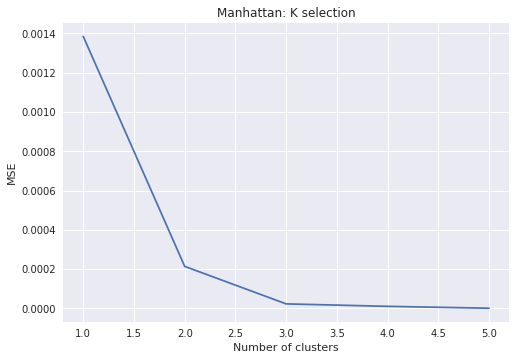

 The number of Kcluster set:  5


In [58]:
# Finding best k
plt.style.use("seaborn")
Ks = 6
mse = np.zeros((Ks-1))
manhattan_grouped_clustering = manhattan_foodcourt.drop('Neighborhood', 1)

for n in range(1,Ks):
    kclusters = n
# run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0,init = 'random', n_init = 15).fit(manhattan_grouped_clustering)
    mse[n-1] = kmeans.inertia_
    
plt.plot(range(1,Ks),mse)
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("Manhattan: K selection")
plt.show()
 
print(' The number of Kcluster set: ', kclusters)

In [59]:
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 0, 0, 0, 2, 0, 0, 4], dtype=int32)

In [60]:
manhattan_merged=manhattan_foodcourt.copy().reset_index(drop=True)
manhattan_merged.head()

,Neighborhood,Food Court
0,Battery Park City,0.025
1,Carnegie Hill,0.000
2,Central Harlem,0.000
3,Chelsea,0.000
4,Chinatown,0.000


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [61]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
manhattan_merged=manhattan_foodcourt.copy()
manhattan_merged = manhattan_data.join(manhattan_foodcourt.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Food Court,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,0.0,0,Sandwich Place,Coffee Shop,Gym,Yoga Studio,Shopping Mall,Steakhouse,Seafood Restaurant,Supplement Shop,Donut Shop,Miscellaneous Shop
1,Manhattan,Chinatown,40.715618,-73.994279,0.0,0,Chinese Restaurant,Cocktail Bar,American Restaurant,Spa,Hotpot Restaurant,Bakery,Optical Shop,Vietnamese Restaurant,Salon / Barbershop,Dessert Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,0.0,0,Café,Bakery,Grocery Store,Chinese Restaurant,Mobile Phone Shop,Coffee Shop,Tapas Restaurant,Mexican Restaurant,Donut Shop,Latin American Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,0.0,0,Mexican Restaurant,Lounge,Café,Restaurant,Pizza Place,Wine Bar,Frozen Yogurt Shop,American Restaurant,Bakery,Chinese Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0.0,0,Pizza Place,Deli / Bodega,Café,Coffee Shop,Mexican Restaurant,Yoga Studio,Sushi Restaurant,Park,Chinese Restaurant,Bakery


In [62]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


## 5. Create a map of Manhattan, New York with neighborhoods superimposed on top.

Finally, let's visualize the resulting clusters

In [63]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + '  cluster  ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius= 5,
        popup=label,
        color=rainbow[cluster-3],
        fill=True,
        fill_color='black'[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
             
map_clusters


## 6. Examine Clusters

Here each cluster is distinguished for each cluster.

#### Cluster 1
Showinhg venues without food courts

In [64]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Food Court,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,0.0,0,Sandwich Place,Coffee Shop,Gym,Yoga Studio,Shopping Mall,Steakhouse,Seafood Restaurant,Supplement Shop,Donut Shop,Miscellaneous Shop
1,Chinatown,0.0,0,Chinese Restaurant,Cocktail Bar,American Restaurant,Spa,Hotpot Restaurant,Bakery,Optical Shop,Vietnamese Restaurant,Salon / Barbershop,Dessert Shop
2,Washington Heights,0.0,0,Café,Bakery,Grocery Store,Chinese Restaurant,Mobile Phone Shop,Coffee Shop,Tapas Restaurant,Mexican Restaurant,Donut Shop,Latin American Restaurant
3,Inwood,0.0,0,Mexican Restaurant,Lounge,Café,Restaurant,Pizza Place,Wine Bar,Frozen Yogurt Shop,American Restaurant,Bakery,Chinese Restaurant
4,Hamilton Heights,0.0,0,Pizza Place,Deli / Bodega,Café,Coffee Shop,Mexican Restaurant,Yoga Studio,Sushi Restaurant,Park,Chinese Restaurant,Bakery
5,Manhattanville,0.0,0,Coffee Shop,Deli / Bodega,Seafood Restaurant,Park,Mexican Restaurant,Italian Restaurant,Bike Trail,Bar,Grocery Store,Chinese Restaurant
6,Central Harlem,0.0,0,Seafood Restaurant,Bar,African Restaurant,American Restaurant,Pizza Place,Art Gallery,French Restaurant,Chinese Restaurant,Fried Chicken Joint,Bookstore
7,East Harlem,0.0,0,Mexican Restaurant,Bakery,Thai Restaurant,Pizza Place,Deli / Bodega,Latin American Restaurant,Spa,Spanish Restaurant,Sandwich Place,Steakhouse
8,Upper East Side,0.0,0,Italian Restaurant,Coffee Shop,Juice Bar,Gym / Fitness Center,Bakery,Yoga Studio,Hotel,Wine Shop,French Restaurant,Exhibit
9,Yorkville,0.0,0,Italian Restaurant,Gym,Coffee Shop,Bar,Deli / Bodega,Pizza Place,Japanese Restaurant,Diner,Sushi Restaurant,Mexican Restaurant


#### Cluster 2
Showing venues with food courts

In [65]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Food Court,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Battery Park City,0.025,1,Park,Hotel,Coffee Shop,Shopping Mall,Gym,Memorial Site,Pizza Place,Food Court,Boat or Ferry,Sandwich Place


#### Cluster 3
Showing venues with food courts

In [66]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Food Court,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Clinton,0.02,2,Theater,Italian Restaurant,Gym / Fitness Center,Coffee Shop,American Restaurant,Spa,Hotel,Sandwich Place,Gym,Mediterranean Restaurant


#### Cluster 4
Showing venues with food courts

In [67]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Food Court,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,Hudson Yards,0.013699,3,American Restaurant,Gym / Fitness Center,Hotel,Coffee Shop,Thai Restaurant,Italian Restaurant,Asian Restaurant,Dog Run,Gym,Park


#### Cluster 5
Showing venues with food courts

In [68]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(4, manhattan_merged.shape[1]))]]

,Neighborhood,Food Court,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Tribeca,0.010989,4,American Restaurant,Italian Restaurant,Park,Café,Coffee Shop,Wine Bar,Spa,Greek Restaurant,Basketball Court,Bakery
29,Financial District,0.010000,4,Coffee Shop,Pizza Place,American Restaurant,Bar,Cocktail Bar,Gym,Gym / Fitness Center,Japanese Restaurant,Park,Wine Shop
33,Midtown South,0.010000,4,Korean Restaurant,Hotel,Japanese Restaurant,Dessert Shop,Coffee Shop,Restaurant,Gym / Fitness Center,Burger Joint,American Restaurant,Cocktail Bar
34,Sutton Place,0.010000,4,Italian Restaurant,Gym / Fitness Center,Gym,Coffee Shop,Furniture / Home Store,Pizza Place,Yoga Studio,Beer Garden,Park,Dessert Shop


This notebook was originally created by [Alex Aklson](https://www.linkedin.com/in/aklson/) and [Polong Lin](https://www.linkedin.com/in/polonglin/), and I have modified it for the purpose of completing this project.

This notebook is part of a course on **Coursera** called *Applied Data Science Capstone*. If you accessed this notebook outside the course, you can take this course online by clicking [here](http://cocl.us/DP0701EN_Coursera_Week3_LAB2).

<hr>

Copyright &copy; 2018 [Cognitive Class](https://cognitiveclass.ai/?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).